# Week 8: Image Clustering with K-Means
Working with my 'neutral-face' dataset

In [186]:
!pip install tensorflow

In [187]:
import random, os, sys, shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import tensorflow.keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

In [188]:
from PIL import Image
import os

# Path to the directory containing neutral images
input_dir = "data/emotion-class/neutral-face"

# save to same output file
output_dir = "data/emotion-class/neutral-face"

# Iterate through each file in the input directory, check if the image file ends with alternate file formats than .jpg
for filename in os.listdir(input_dir):
   # If file ends in .png...
    if filename.lower().endswith('.png'): # code adapted from : https://stackoverflow.com/questions/889333/how-to-check-if-a-file-is-a-valid-image-file
        # open image file
        with Image.open(os.path.join(input_dir, filename)) as img:
            # then convert and save the image as .jpg format in the output directory
            img.convert("RGB").save(os.path.join(output_dir, f"{os.path.splitext(filename)[0]}.jpg"))

In [189]:
from PIL import Image
import os

# Path to the directory containing images
input_dir = "data/emotion-class/neutral-face"
output_dir = "data/emotion-class/neutral-face-bw"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate through each file in the input directory
for filename in os.listdir(input_dir):
    if filename.lower().endswith('.jpg'):  # Check if the file is a JPEG image
        with Image.open(os.path.join(input_dir, filename)) as img:
            # Convert the image to grayscale
            img_bw = img.convert('L')
            # Save the black and white image to the output directory
            img_bw.save(os.path.join(output_dir, filename))

# Load and resize images 

We load in all the images and resize them to 224 x 224, as this is the resolution we need for inputting to MobileNet

In [190]:
#Path to folder
path_to_images = "data/emotion-class/neutral-face-bw"
#image extension
file_type = ".jpg"
#Pick image size
img_height = 224
img_width = 224
#Is it rgb or black and white?
channels = 3

In [191]:
#Get all paths
paths = []
for root, dirs, files in os.walk(path_to_images, topdown=False):
    for name in files:
        if file_type in name.lower():
            paths.append(str(os.path.join(root, name)))
#Load in images
dataset = [np.array(img_to_array(load_img(i,target_size=((img_height,img_width)))))/255.0 for i in paths]
dataset = np.array(dataset).astype("float32")
dataset.shape

(173, 224, 224, 3)

In [192]:
# Load in pre-trained model
model = tensorflow.keras.applications.MobileNetV2(input_shape=(224,224,3), alpha=1.0, weights='imagenet', pooling=None)

# Get image features
pred = model.predict(dataset)
print(pred.shape)
x = pred.reshape(dataset.shape[0], -1)

6/6 [==============================] - 4s 443ms/step
(173, 1000)


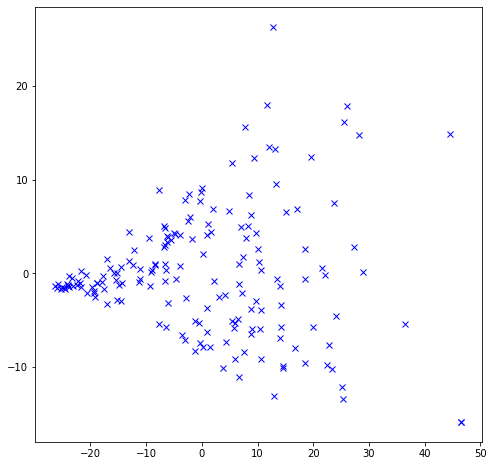

In [193]:
# Clustering
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardise
x = StandardScaler().fit_transform(x)

# Plot in 2D, first reducing the dataset
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)

#Plot
plt.figure(figsize=(8, 8))
a = plt.plot(x_2d[:,0],x_2d[:,1],"bx")

In [194]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='r', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)
    plot_centroids(clusterer.cluster_centers_)

### Elbow Plot

Whats the best value of **k**? We can look for the **elbow** that shows a big jump in **inertia** before a flattening off. Here we plot the first 20 values of k.

Remember, this is just a guide to help you pick a value of k and other factors may be involved in your final decision 

/Users/nixi/anaconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nixi/anaconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nixi/anaconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nixi/anaconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default valu

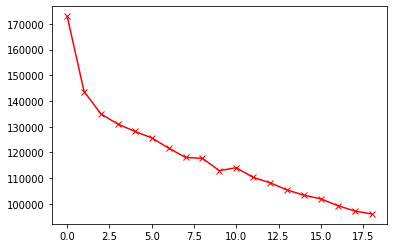

In [195]:
scores=[]
for i in range(1,20):
    #Fit for k
    means=KMeans(n_clusters=i)
    means.fit(x)
    
    #Get inertia
    scores.append(means.inertia_)
plt.plot(scores,"-rx")

# Cluster and Plot

First try with all the features. 

You may find that your clusters and their centres don't look right. Remember, we are clustering based on **all** of the features, and then reducing down to 2 dimensions to plot. 

/Users/nixi/anaconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


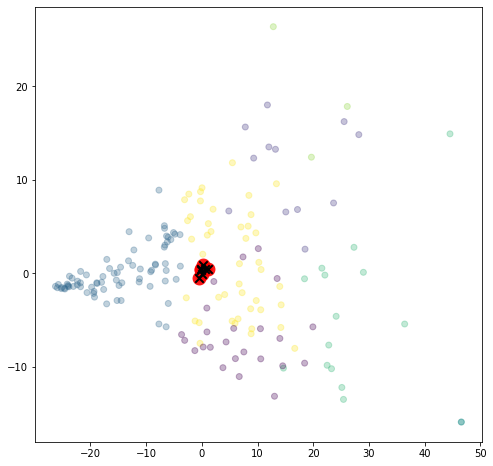

In [196]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x)
cluster_labels = kmeans.predict(x)
plt.figure(figsize=(8, 8))
#Plot clusters onto PCA reduced plot
plot_clusters(kmeans, x)

### Reducing Dimensions before clustering

You can also try reducing the dimensions before clustering, which may give you better results.

/Users/nixi/anaconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


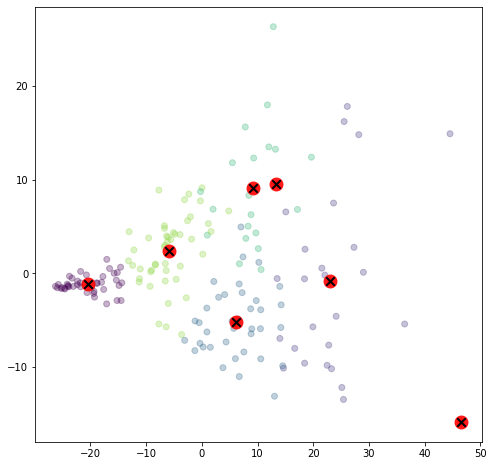

In [197]:
#How many dimensions to reduce to (before clustering)?
num_dimensions = 20

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x)

#Fit cluster
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x_less_dimensions)

#Plot results
plt.figure(figsize=(8, 8))
plot_clusters(kmeans, x_less_dimensions)

# Examine Clusters
### Examine representative images

For each image, we not only get the cluster that it has been asigned to, but also the distance to the centre of that cluster. 

This means we can get the images closest to the centre of each cluster and these should be the most representative. 

This code prints out the top 3 for each cluster.

In [198]:
#Define this custom function to display images in grid
from PIL import Image
from PIL import ImageDraw 
from PIL import ImageFont

font = ImageFont.truetype("../data/Arial.ttf", 24)
#Define custom function to display images
def image_grid(imgs, rows, cols, labels = False):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    draw = ImageDraw.Draw(grid)
    for i, img in enumerate(imgs):
        r = i//cols
        c = i%cols
        pt = (c*w, r*h)
        color = (255,255,255)
        grid.paste(img, box=pt)
        if labels:
            label = "Cluster "+str(r) 
            draw.text(pt,label,color,font=font)
    return grid

### Pick your number of clusters

In [346]:
#How many clusters?
k = 4
#Get image closest to the centre for each cluster
kmeans = KMeans(n_clusters=k, random_state=42)
#dist to each cluster center for each image
x_dist = kmeans.fit_transform(x_less_dimensions)

/Users/nixi/anaconda3/envs/stem/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [347]:
# Start a cluster label column which will be useful for the latter of this project, which attempts to find graphical similarities between the feature landmarks for each cluster as a reason as to why the algorithm grouped the image dataset together.
cluster_data = {}

len(cluster_labels)
#for cluster_label in range(k):
   

173

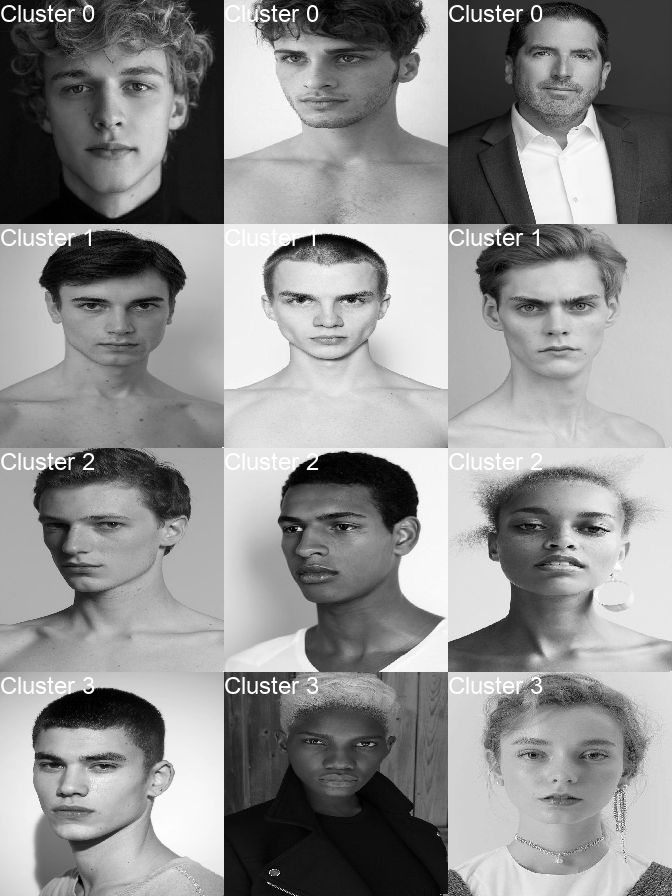

<Figure size 720x720 with 0 Axes>

In [348]:
cols = 3
indexes = np.array([]).astype(int)
for i in range(k):
    #Get distances for a given cluster (for all images)
    cluster_dist = x_dist[:,i]
    #Sort ascending (shortest distance first) and take nearest 3
    cluster_indexes = cluster_dist.argsort(axis = 0)[:cols]
    indexes = np.concatenate((indexes,cluster_indexes))
    
to_show = dataset[indexes]
to_show = [array_to_img(i) for i in to_show]
plt.figure(figsize=(10,10))

image_grid(to_show, k, cols, True)

### Examine most representative images for a given cluster

Here we can dive deeper and print out more images from a given cluster

Images Nearest the Centre of Cluster 0


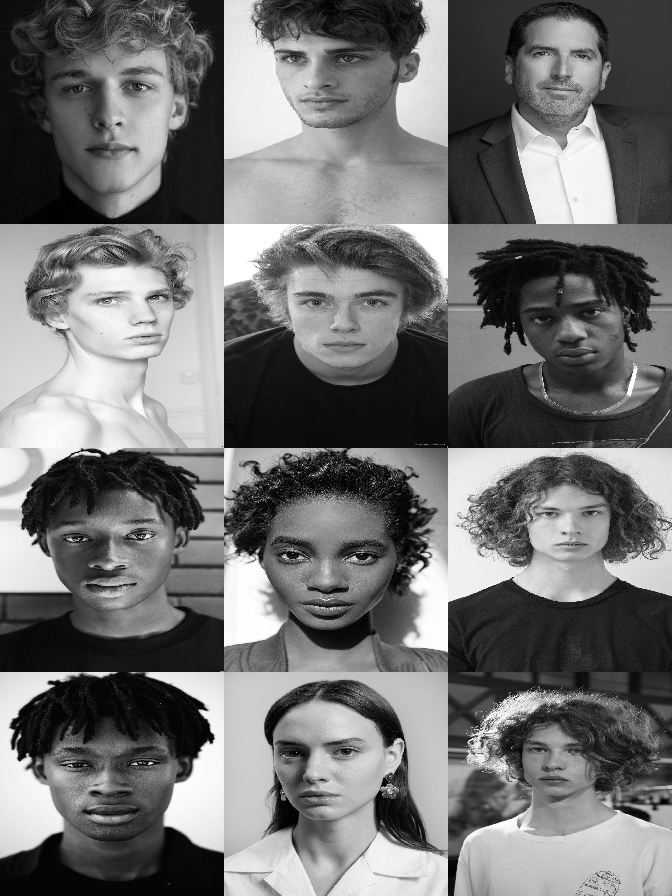

<Figure size 720x720 with 0 Axes>

In [297]:
#What cluster do you want to look at?
cluster = 0
#How many images do you want to see?
num_to_show = 12

cluster_dist = x_dist[:,cluster]
#Sort ascending (shortest distance first)
representative_indexes = cluster_dist.argsort(axis = 0)
representative_ims = dataset[representative_indexes]
to_show = representative_ims[:num_to_show]
to_show = [array_to_img(i) for i in to_show]
plt.figure(figsize=(10,10))

#How to display images (rows x cols should equal num_images!)
print("Images Nearest the Centre of Cluster " + str(cluster)) 
image_grid(to_show, 4, 3)

Images Nearest the Centre of Cluster 1


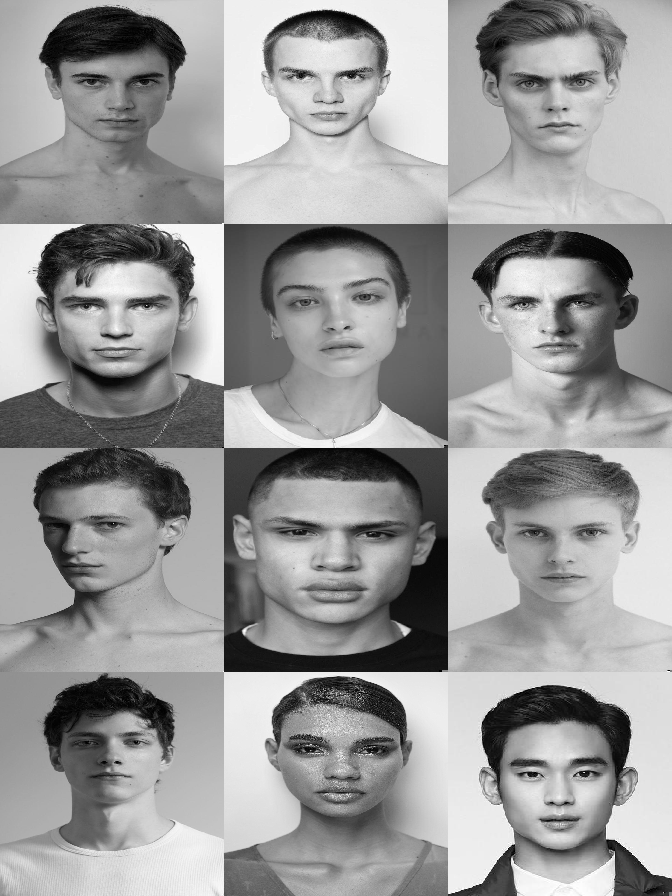

<Figure size 720x720 with 0 Axes>

In [298]:
cluster = 1

num_to_show = 12

cluster_dist = x_dist[:,cluster]
#Sort ascending (shortest distance first)
representative_indexes = cluster_dist.argsort(axis = 0)
representative_ims = dataset[representative_indexes]
to_show = representative_ims[:num_to_show]
to_show = [array_to_img(i) for i in to_show]
plt.figure(figsize=(10,10))

#How to display images (rows x cols should equal num_images!)
print("Images Nearest the Centre of Cluster " + str(cluster)) 
image_grid(to_show, 4, 3)

Images Nearest the Centre of Cluster 2


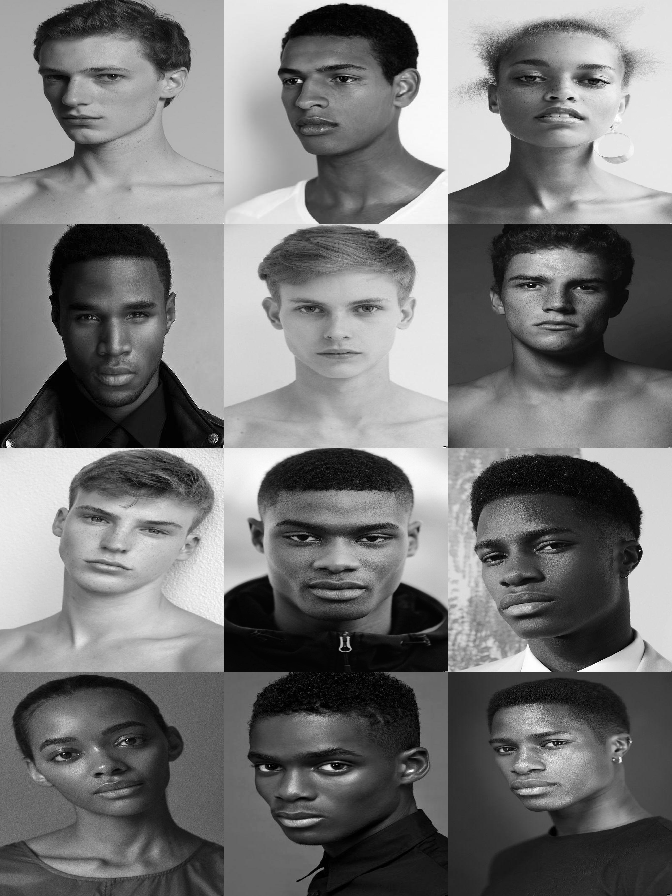

<Figure size 720x720 with 0 Axes>

In [299]:
cluster = 2

num_to_show = 12
cluster_dist = x_dist[:,cluster]
#Sort ascending (shortest distance first)
representative_indexes = cluster_dist.argsort(axis = 0)
representative_ims = dataset[representative_indexes]
to_show = representative_ims[:num_to_show]
to_show = [array_to_img(i) for i in to_show]
plt.figure(figsize=(10,10))

#How to display images (rows x cols should equal num_images!)
print("Images Nearest the Centre of Cluster " + str(cluster)) 
image_grid(to_show, 4, 3)

Images Nearest the Centre of Cluster 3


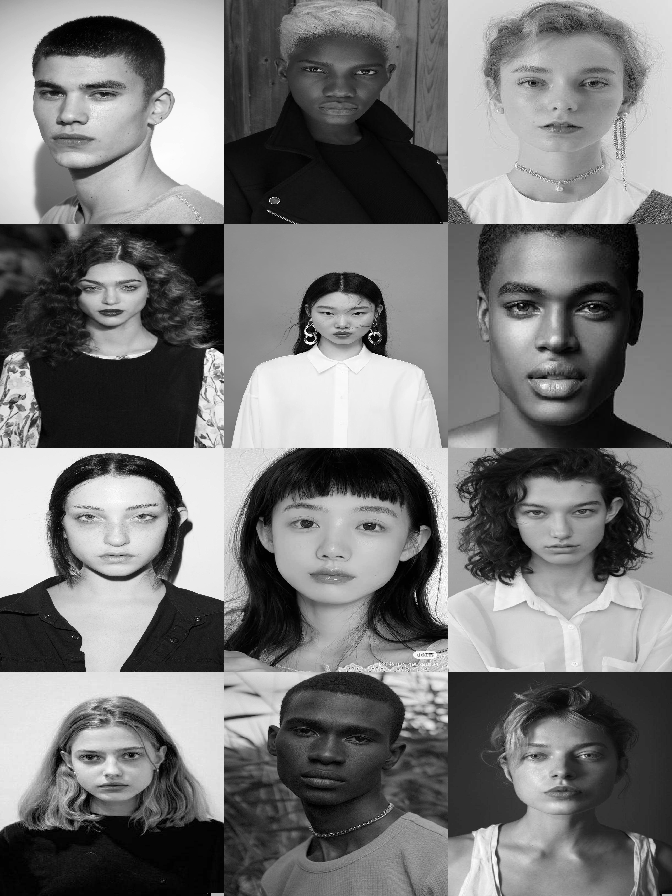

<Figure size 720x720 with 0 Axes>

In [300]:
cluster = 3

num_to_show = 12
cluster_dist = x_dist[:,cluster]
#Sort ascending (shortest distance first)
representative_indexes = cluster_dist.argsort(axis = 0)
representative_ims = dataset[representative_indexes]
to_show = representative_ims[:num_to_show]
to_show = [array_to_img(i) for i in to_show]
plt.figure(figsize=(10,10))

#How to display images (rows x cols should equal num_images!)
print("Images Nearest the Centre of Cluster " + str(cluster)) 
image_grid(to_show, 4, 3)

#### Feature correlation and statistical analysis comparing feature distributions

The following code has been adapted for this project, from my previous project for another module (AI for Media). The link to my repository can be found at: https://github.com/n1cffz/AI-for-Media-project-23-24 

In [272]:
import cv2
import os
import pandas as pd

# Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml')

# Path to the directory containing your images
directory_path = 'data/emotion-class/neutral-face-bw'

# Initialize a list to store image features
image_features = []

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load the image
        image = cv2.imread(os.path.join(directory_path, filename))
        
        # Convert the image to grayscale for feature extraction
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        # Extract features (e.g., number of faces, face areas) from the image
        num_faces = len(faces)
        total_face_area = sum([w*h for (x, y, w, h) in faces])
        
        # Append the extracted features to the list
        image_features.append({'Image': filename, 'NumFaces': num_faces, 'TotalFaceArea': total_face_area})

# Create a DataFrame from the extracted image features
df = pd.DataFrame(image_features)

# Display the DataFrame with image features
print(df)

                                 Image  NumFaces  TotalFaceArea
0    pinterest_1105774514745986254.jpg         1          75076
1     pinterest_591801207284228921.jpg         1          76729
2    pinterest_1105774514745986334.jpg         1         271441
3     pinterest_591801207283449312.jpg         1         118336
4    pinterest_1105774514745986321.jpg         1         450241
..                                 ...       ...            ...
168  pinterest_1105774514745986270.jpg         1         127449
169   pinterest_510173464046433518.jpg         1         370881
170  pinterest_1105774514745986271.jpg         1         244036
171   pinterest_591801207285737483.jpg         1         119716
172   pinterest_591801207283449280.jpg         1          39204

[173 rows x 3 columns]


### Facial feature landmark detection

In [323]:
import dlib

# Code debugged  using GPT and adapted from https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/tree/main/Week-4-Sensing-bodies and https://dontrepeatyourself.org/post/how-to-detect-face-landmarks-with-dlib-python-and-opencv/?utm_content=cmp-true
# Define directory
input_dir = "data/emotion-class/neutral-face-bw"

# Load the pre-trained facial landmark detector from dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


# Create an empty list for the following data...
image_details = []

# Iterate through each image in directory
for filename in os.listdir(input_dir):
    image_path = os.path.join(input_dir, filename)
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        
        # Variables to store landark data
        eyes_x, eyes_y, nose_x, nose_y, mouth_x, mouth_y = [], [], [], [], [], []
        
        # Extract landmark coordinates for eyes, nose, and mouth
        # Eyes
        for n in range(36, 48):  
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            eyes_x.append(x)
            eyes_y.append(y)
        
        # Nose
        for n in range(27, 35):  
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            nose_x.append(x)
            nose_y.append(y)
        
        for n in range(48, 68):  # Landmarks for mouth
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            mouth_x.append(x)
            mouth_y.append(y)
        
        # Append the extracted details to the list
        image_details.append({'Image': filename, 'Eyes_X': eyes_x, 'Eyes_Y': eyes_y, 
                              'Nose_X': nose_x, 'Nose_Y': nose_y, 'Mouth_X': mouth_x, 'Mouth_Y': mouth_y})

# Create a DataFrame from the extracted image details
df_details = pd.DataFrame(image_details)

print(df_details)

                                 Image  \
0    pinterest_1105774514745986254.jpg   
1     pinterest_591801207284228921.jpg   
2    pinterest_1105774514745986334.jpg   
3     pinterest_591801207283449312.jpg   
4    pinterest_1105774514745986321.jpg   
..                                 ...   
167  pinterest_1105774514745986270.jpg   
168   pinterest_510173464046433518.jpg   
169  pinterest_1105774514745986271.jpg   
170   pinterest_591801207285737483.jpg   
171   pinterest_591801207283449280.jpg   

                                                Eyes_X  \
0    [290, 307, 324, 338, 322, 304, 402, 416, 432, ...   
1    [388, 403, 420, 433, 417, 400, 501, 516, 533, ...   
2    [183, 213, 247, 272, 241, 209, 410, 438, 472, ...   
3    [167, 183, 204, 220, 201, 181, 292, 308, 329, ...   
4    [285, 323, 367, 405, 359, 316, 561, 599, 642, ...   
..                                                 ...   
167  [120, 137, 159, 177, 157, 136, 260, 277, 299, ...   
168  [143, 176, 216, 253, 214, 

#### Plot graphs for each cluster showing the eye and nose landmarks

In [327]:
# What are my cluster labels?
print("Cluster labels:")
print(cluster_labels) 

Cluster labels:
[6 1 4 0 6 6 6 4 2 0 2 2 0 2 6 2 6 6 1 2 2 4 1 2 2 2 2 2 5 2 2 2 6 1 0 2 6
 4 6 6 6 2 2 6 0 2 2 1 1 2 6 6 2 2 2 4 2 6 0 0 1 2 2 6 6 2 6 0 1 4 2 2 2 2
 2 0 6 6 4 6 2 6 6 1 0 6 2 0 6 2 4 5 2 2 2 6 0 0 2 2 6 0 2 2 6 2 0 2 0 4 2
 0 2 6 2 2 3 6 0 6 2 2 2 6 2 4 6 6 4 2 2 2 2 2 2 2 6 2 1 2 6 2 6 1 0 6 2 6
 2 4 5 4 2 1 2 6 6 2 2 0 6 2 6 0 3 2 0 2 4 2 0 2 0]


In [332]:
cluster_indices = {}

# Group indices based on cluster labels
for idx, label in enumerate(cluster_labels):
    if label not in cluster_indices:
        cluster_indices[label] = [idx]
    else:
        cluster_indices[label].append(idx)

# Print the list of indices for each cluster
for cluster_label, indices in cluster_indices.items():
    print(f"Cluster {cluster_label} indices: {indices}")

Cluster 6 indices: [0, 4, 5, 6, 14, 16, 17, 32, 36, 38, 39, 40, 43, 50, 51, 57, 63, 64, 66, 76, 77, 79, 81, 82, 85, 88, 95, 100, 104, 113, 117, 119, 123, 126, 127, 136, 140, 142, 145, 147, 155, 156, 160, 162]
Cluster 1 indices: [1, 18, 22, 33, 47, 48, 60, 68, 83, 138, 143, 153]
Cluster 4 indices: [2, 7, 21, 37, 55, 69, 78, 90, 109, 125, 128, 149, 151, 168]
Cluster 0 indices: [3, 9, 12, 34, 44, 58, 59, 67, 75, 84, 87, 96, 97, 101, 106, 108, 111, 118, 144, 159, 163, 166, 170, 172]
Cluster 2 indices: [8, 10, 11, 13, 15, 19, 20, 23, 24, 25, 26, 27, 29, 30, 31, 35, 41, 42, 45, 46, 49, 52, 53, 54, 56, 61, 62, 65, 70, 71, 72, 73, 74, 80, 86, 89, 92, 93, 94, 98, 99, 102, 103, 105, 107, 110, 112, 114, 115, 120, 121, 122, 124, 129, 130, 131, 132, 133, 134, 135, 137, 139, 141, 146, 148, 152, 154, 157, 158, 161, 165, 167, 169, 171]
Cluster 5 indices: [28, 91, 150]
Cluster 3 indices: [116, 164]


In [330]:
###  Clean facial landmark data 
# In this instance, i am looking at the mouth points so i need to access the x and y rows within my Dataframe using the iterrows() function
#for index, row in df_combined.iterrows():
#    mouth_x_values = row['Mouth_X']
#    print(mouth_x_values)
#    mouth_y_values = row['Mouth_Y']
#    print("Mouth y values", mouth_y_values)
 

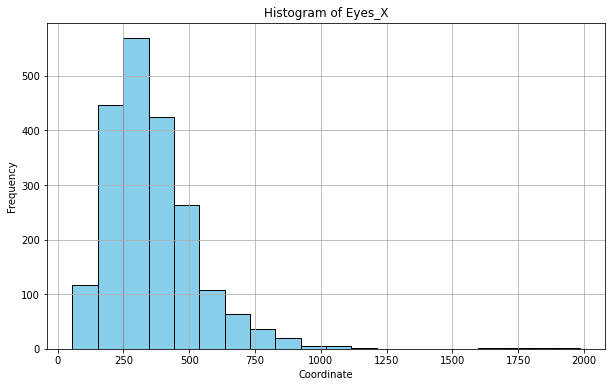

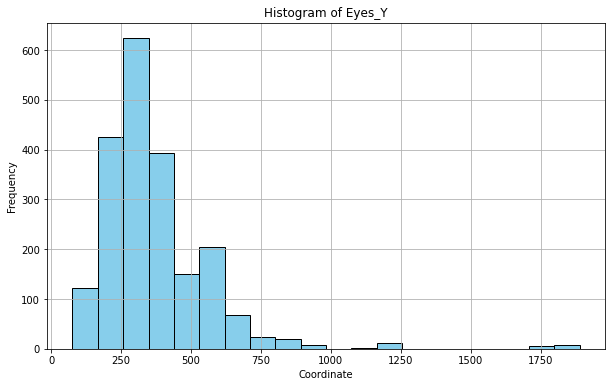

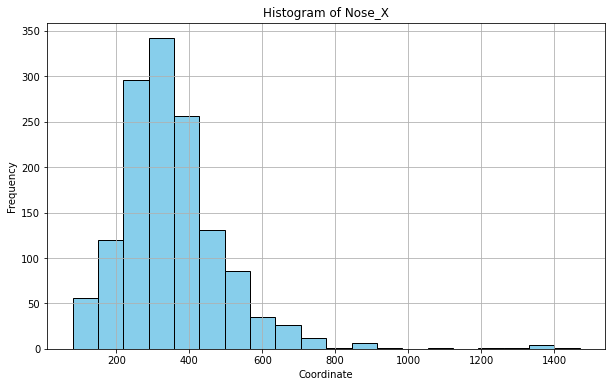

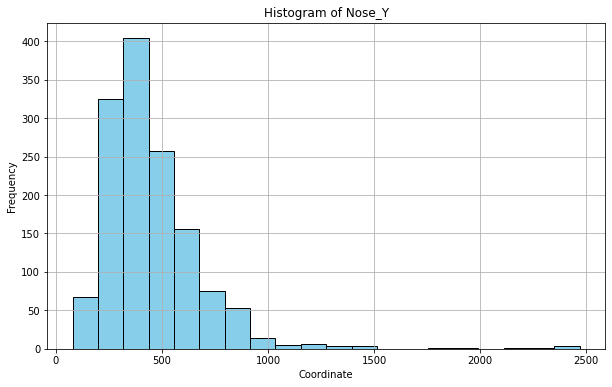

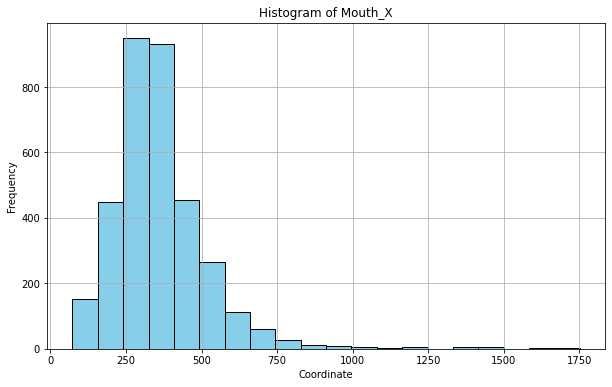

In [331]:
# Plot histogram for facial features (Eyes_X/Y, Nose_X/Y,Mouth_X/Y ) to see if there are any patterns.

def plot_landmark_histograms(df_details, landmark_name):
    # Flatten the nested list of landmark coordinates
    landmark_coords_flat = np.concatenate(df_details[landmark_name].values)

    plt.figure(figsize=(10, 6))
    plt.hist(landmark_coords_flat, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {landmark_name}')
    plt.xlabel('Coordinate')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot histograms for eye landmarks
plot_landmark_histograms(df_details, 'Eyes_X')
plot_landmark_histograms(df_details, 'Eyes_Y')

# Plot histograms for nose landmarks
plot_landmark_histograms(df_details, 'Nose_X')
plot_landmark_histograms(df_details, 'Nose_Y')

# Plot histograms for mouth landmarks
plot_landmark_histograms(df_details, 'Mouth_X')
plot_landmark_histograms(df_details, 'Mouth_Y')

In [349]:
import numpy as np
from PIL import Image
import IPython.display

# Code adapted from: https://git.arts.ac.uk/lmccallum/STEM-4-Creatives-23-24/blob/main/STEM-Week-6-Images.ipynb and debugged with GPT
# Consider whether the black and white intensity values have been considered when clustering ( I noticed some clusters had patterns with light and dark pictures)
cluster_data = {}

# Initialize an empty list to store cluster labels
cluster_labels_list = []

# Convert cluster_labels to a numpy array
cluster_labels = np.array(cluster_labels)

for i in range(k):
    # Get distances for a given cluster (for all images)
    cluster_dist = x_dist[:, i]
    # Sort ascending (shortest distance first) and take nearest 3
    cluster_indexes = cluster_dist.argsort(axis=0)[:cols]
    # Store cluster labels for the selected indexes
    cluster_labels_list.extend(cluster_labels[cluster_indexes])

# Add cluster labels to the cluster_data dictionary
cluster_data['Cluster_Labels'] = cluster_labels_list

cluster_intensities = {}

# Iterate over unique cluster labels
for label in np.unique(cluster_labels):
    # Get the indexes of images belonging to the current cluster label
    cluster_indexes = np.where(cluster_labels == label)[0]
    
    # Calculate the average intensity for the current cluster
    cluster_intensity = np.mean(dataset[cluster_indexes])
    
    # Store the cluster intensity in the dictionary
    cluster_intensities[label] = cluster_intensity

# Print or visualize the cluster intensities
for label, intensity in cluster_intensities.items():
    print(f"Cluster {label} intensity: {intensity}")

Cluster 0 intensity: 0.5882496237754822
Cluster 1 intensity: 0.5063718557357788
Cluster 2 intensity: 0.4679133892059326
Cluster 3 intensity: 0.5214444398880005
Cluster 4 intensity: 0.5077242851257324
Cluster 5 intensity: 0.5701883435249329
Cluster 6 intensity: 0.4341481626033783
